# Exploring the Relationship Between Hours Played in Minecraft using Age and Subscription Status  

## Introduction 

This project investigates the question: how will we use factors like age and whether the player subscribes to a gaming newsletter to predict the hours played by a player. And to determine the type of player that would contribute a lot of data. To answer this, we will use data analysis and a K-Nearest Neighbors (KNN) regression model to examine the relationship between player's traits and total recorded playtime.

## Loading and Wrangling Data 

Two Data sets were imported to GitHub and loaded in jupyter notebook.

In [1]:
set.seed(2020)
library(readr)
library(lubridate)
library(ggplot2)
library(dplyr)
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)

players <- read.csv("players.csv")
sessions <- read.csv("sessions.csv")

cat("Players dataset:", nrow(players), "rows,", ncol(players), "columns\n")
cat("Sessions dataset:", nrow(sessions), "rows,", ncol(sessions), "columns\n")

glimpse(players)
glimpse(sessions)


Attaching package: ‘lubridate’


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ forcats 1.0.0     ✔ tibble  3.2.1
✔ purrr   1.0.2     ✔ tidyr   1.3.1
✔ stringr 1.5.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4

Players dataset: 196 rows, 7 columns
Sessions dataset: 1535 rows, 5 columns
Rows: 196
Columns: 7
$ experience   <chr> "Pro", "Veteran", "Veteran", "Amateur", "Regular", "Amate…
$ subscribe    <lgl> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ hashedEmail  <chr> "f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ name         <chr> "Morgan", "Christian", "Blake", "Flora", "Kylie", "Adrian…
$ gender       <chr> "Male", "Male", "Male", "Female", "Male", "Female", "Fema…
$ Age          <int> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
Rows: 1,535
Columns: 5
$ hashedEmail         <chr> "bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8a…
$ start_time          <chr> "30/06/2024 18:12", "17/06/2024 23:33", "25/07/202…
$ end_time            <chr> "30/06/2024 18:24", "17/06/2024 23:46", "25/07/202…
$ original_start_time <dbl> 1.71977e+12, 1.71867e+12, 1.72193e+12, 1.72188e+12…


**Data set Descriptions:** \
**players.csv** – contains demographic and subscription information for each player \
**sessions.csv** – contains logs of individual gameplay sessions with start and end timestamps \
**Tables 1-2** contains all information pertaining to the variables found in these data sets

**Table 1: Dataset Descriptions** 
| Dataset        | Observations | Variables | Description                                                     |
| -------------- | ------------ | --------- | --------------------------------------------------------------- |
| `players.csv`  | 196          | 7         | Contains demographic and experience information for each player |
| `sessions.csv` | 1535         | 5         | Contains detailed time records of each player’s gaming sessions | 

**Table 2: Variable Descriptions** 

| Variable       | Type      | Description                                                                  |
| -------------- | --------- | ---------------------------------------------------------------------------- |
| `experience`   | Character | The player’s experience level (e.g., *Amateur*, *Regular*, *Pro*, *Veteran*) |
| `subscribe`    | Logical   | Whether the player has an active subscription (TRUE/FALSE)                   |
| `hashedEmail`  | Character | Anonymized unique identifier for each player, used to link across datasets   |
| `played_hours` | Numeric   | Total hours the player has played so far                                     |
| `name`         | Character | Player’s in-game name                                                        |
| `gender`       | Character | Player’s gender (*Male* or *Female*)                                         |
| `Age`          | Integer   | Player’s age (in years)                                                      |

| Variable              | Type      | Description                                                     |
| --------------------- | --------- | --------------------------------------------------------------- |
| `hashedEmail`         | Character | Both data has that as a unique identifier   |
| `start_time`          | Character | The start time of the game session |
| `end_time`            | Character | The end time of the game session                                |
| `original_start_time` | Numeric   | Unix-style timestamp representing the start of the session      |
| `original_end_time`   | Numeric   | Unix-style timestamp representing the end of the session        |

**Data Wrangling:** \
The session data required cleaning before analysis. So we split the combined timestamps into separate date and time fields. We then reconstructed these into proper date variables (start_dt, end_dt).
Followed by computing the length of each session as using the equation, *duration_hours = end_dt – start_dt*. 

We then aggregated sessions per player to calculate: 

1. total_hours_played 

2. session_count   

These summaries were merged back into the player dataset to create *full_data*, containing demographic information and total hours played for each individual.

In [2]:
players<-read_csv("https://raw.githubusercontent.com/danayong25-cell/Group-Final-Project/refs/heads/main/players.csv")

sessions<-read_csv("https://raw.githubusercontent.com/danayong25-cell/Group-Final-Project/refs/heads/main/sessions.csv")|>
    separate(start_time,into=c("start_date","start_time"),sep=" ")|>
    separate(end_time,into=c("end_date","end_time"),sep=" ")|>
        mutate(
            start_dt = as.POSIXct(paste(start_date,start_time),format="%d/%m/%Y %H:%M"),
            end_dt = as.POSIXct(paste(end_date,end_time),format="%d/%m/%Y %H:%M"),
            duration_hours= as.numeric(difftime(end_dt,start_dt,units="hours"))
        )
head(sessions)


Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_date,start_time,end_date,end_time,original_start_time,original_end_time,start_dt,end_dt,duration_hours
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dttm>,<dttm>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024,18:12,30/06/2024,18:24,1.71977e+12,1.71977e+12,2024-06-30 18:12:00,2024-06-30 18:24:00,0.2000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024,23:33,17/06/2024,23:46,1.71867e+12,1.71867e+12,2024-06-17 23:33:00,2024-06-17 23:46:00,0.2166667
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024,17:34,25/07/2024,17:57,1.72193e+12,1.72193e+12,2024-07-25 17:34:00,2024-07-25 17:57:00,0.3833333
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024,03:22,25/07/2024,03:58,1.72188e+12,1.72188e+12,2024-07-25 03:22:00,2024-07-25 03:58:00,0.6000000
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024,16:01,25/05/2024,16:12,1.71665e+12,1.71665e+12,2024-05-25 16:01:00,2024-05-25 16:12:00,0.1833333
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024,15:08,23/06/2024,17:10,1.71916e+12,1.71916e+12,2024-06-23 15:08:00,2024-06-23 17:10:00,2.0333333


In [3]:
player_sessions<-sessions|>
    group_by(hashedEmail) |>
    summarise(
    total_hours = sum(duration_hours, na.rm = TRUE),
    session_count = n()
    )
player_sessions|>
    summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))

total_hours,session_count
<dbl>,<dbl>
10.4,12.28


In [4]:
full_data<-players|>
    left_join(player_sessions,by="hashedEmail")
head(full_data)

experience,subscribe,hashedEmail,played_hours,name,gender,Age,total_hours,session_count
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<int>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,33.65000000,27
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,4.25000000,3
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,0.08333333,1
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,0.83333333,1
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21,0.15000000,1
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17,NA,NA


While wrangling, some NAs were present in the dataset. 

In order to tidy the data, these NAs were removed using the *summarize across* function along with *na.rm* = TRUE. 

In [5]:
summary(sessions$duration_hours)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0500  0.1500  0.5000  0.8476  1.2167  4.3167       2 

In [6]:
players|>
    summarise(across(where(is.numeric), ~ round(mean(.x, na.rm = TRUE), 2)))

played_hours,Age
<dbl>,<dbl>
5.85,21.14


## Exploratory Data Analysis

To better understand the data, several visualizations were created:

1. Histogram of total hours played to examine the overall distribution of play time.
2. Boxplot of total time played *(hours)* by subscription status to see if newsletter subscribers play more or less.
3. Scatterplot of age vs. total hours to explore how age relates to play time.

These plots provided initial intuition on potential predictors of player engagement.

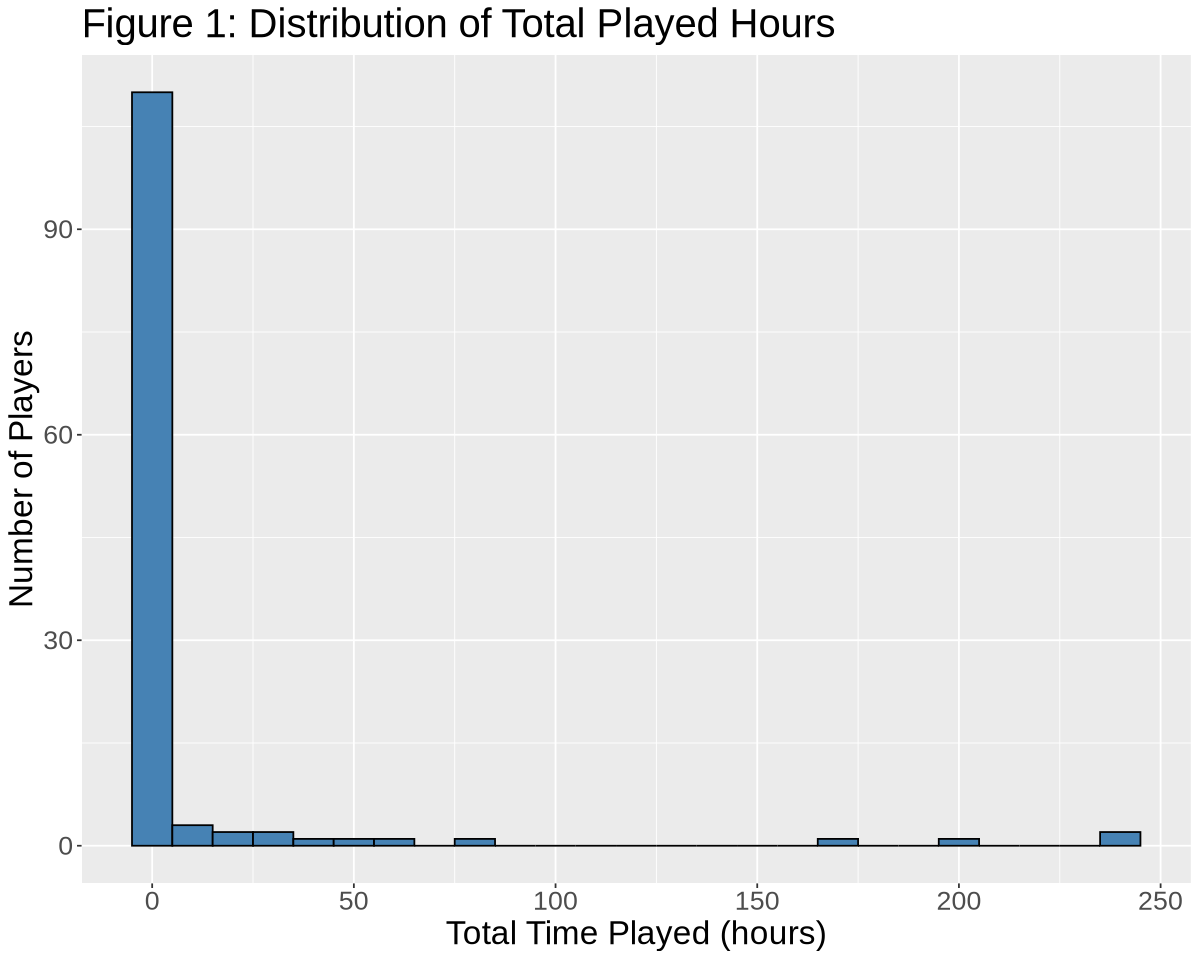

In [7]:
options(repr.plot.width=10,repr.plot.height=8)
total_hours_histogram<-ggplot(full_data |> filter(!is.na(total_hours)), aes(x = total_hours)) +
    geom_histogram(binwidth = 10, fill = "steelblue", color = "black") +
    labs(title = "Figure 1: Distribution of Total Played Hours",
         x = "Total Time Played (hours)",
         y = "Number of Players")+
    theme(text=element_text(size=20))
total_hours_histogram

Looking at the distribution in *Figure 1*, it can be said that majority of players play around 1 hour per session. The distribution is heavily skewed to the left and centered around 0-1 hours of playtime.

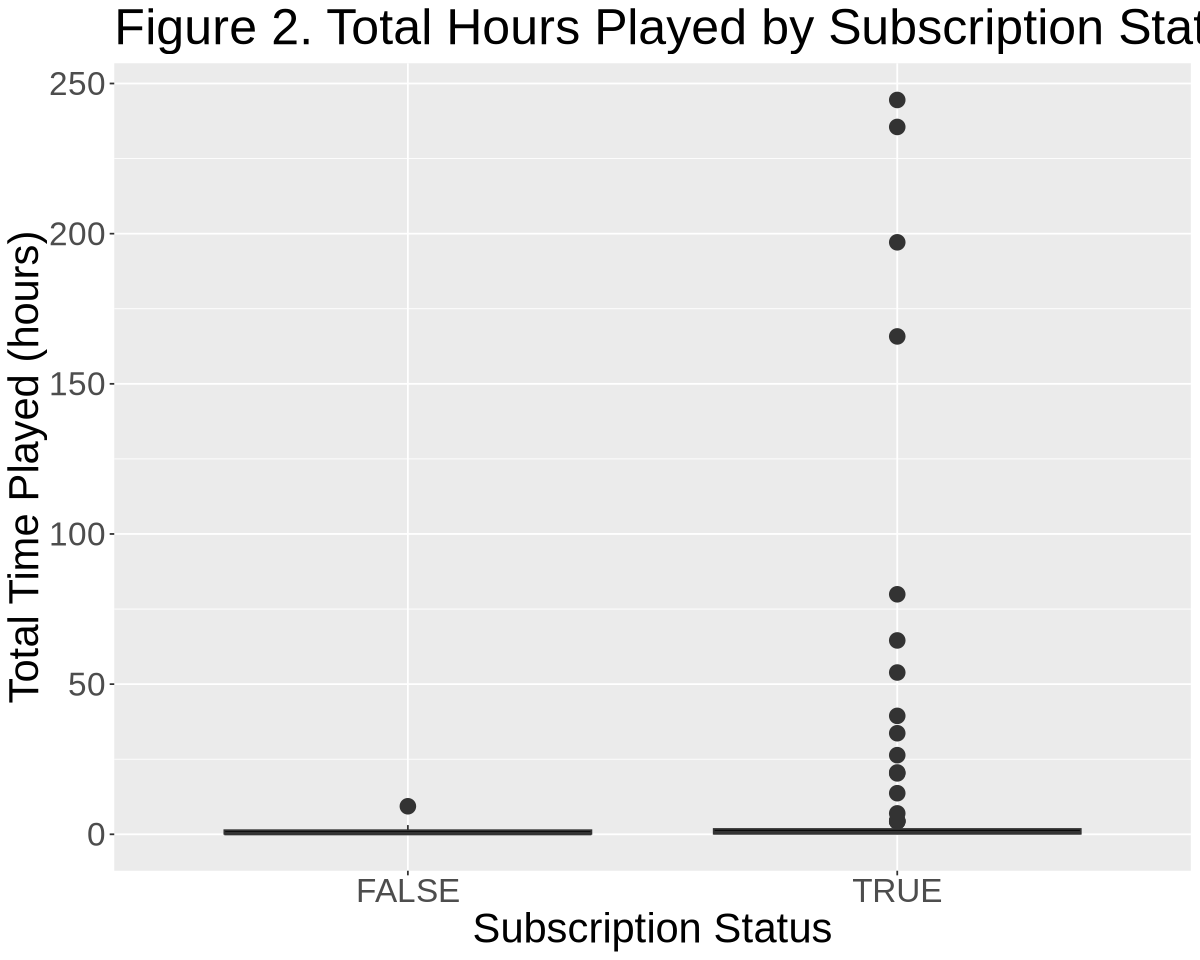

In [8]:
options(repr.plot.width=10,repr.plot.height=8)
total_hours_boxplot <- ggplot(full_data |> filter(!is.na(total_hours)), aes(x = subscribe, y = total_hours)) +
    geom_boxplot(fill = "black", outlier.size=4) +
    labs(title = "Figure 2. Total Hours Played by Subscription Status",
         x = "Subscription Status",
         y = "Total Time Played (hours)")+
    theme(text=element_text(size=25))
total_hours_boxplot

There is a empty section between 100-150 in total time played with those who are subscribed, which may mean that those that game for the longest tend to be subscribed. There are also more people subscribed than not that contribute hours played, which makes it seem like there are very few people who play minecraft that aren't subscribed. 

Warning message:
“Removed 6 rows containing missing values or values outside the scale range
(`geom_point()`).”


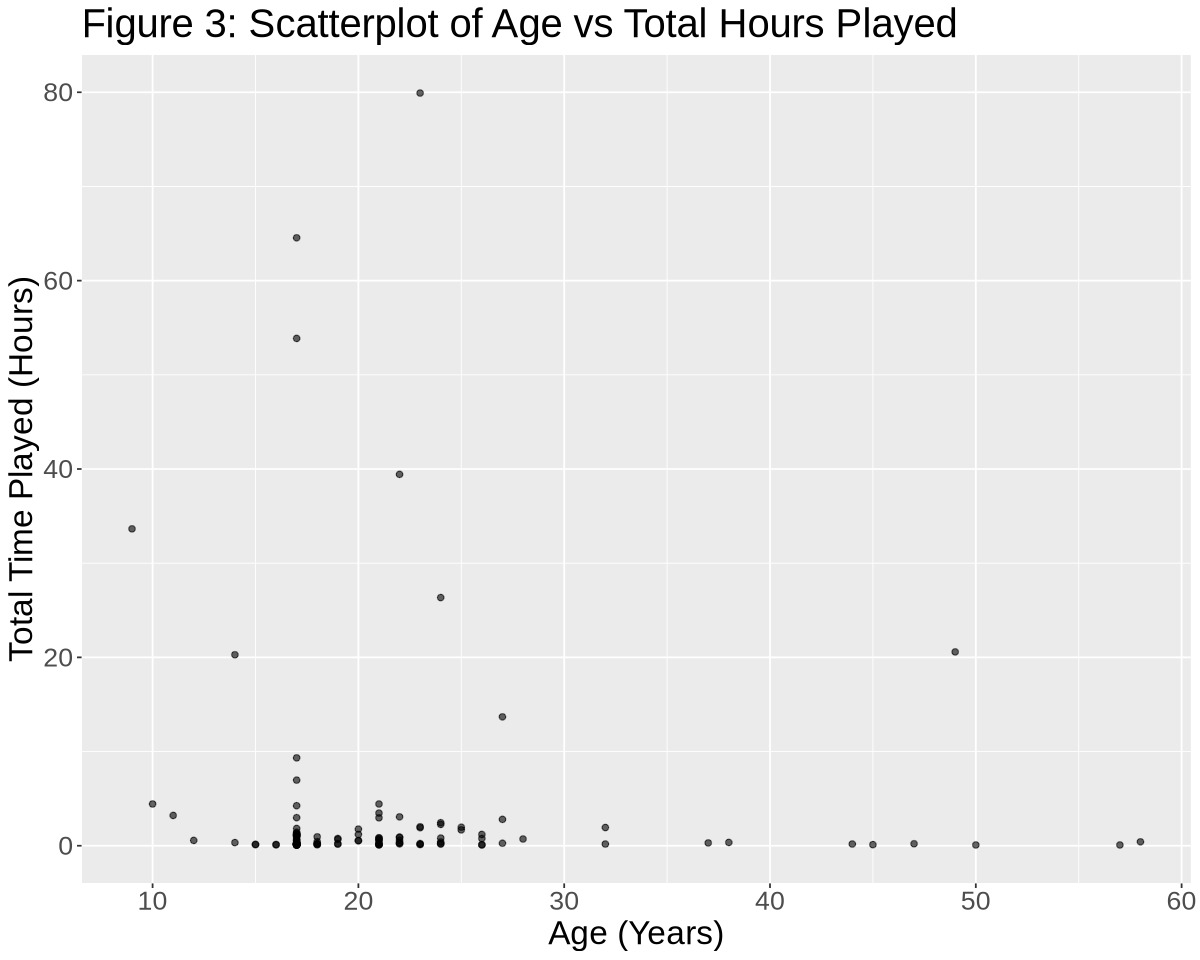

In [9]:
options(repr.plot.width=10,repr.plot.height=8)
total_hours_scatterplot<-ggplot(full_data |> filter(!is.na(total_hours)), aes(x = Age, y = total_hours)) +
  geom_point(alpha = 0.6, color = "black") +
  labs(title = "Figure 3: Scatterplot of Age vs Total Hours Played",
       x = "Age (Years)",
       y = "Total Time Played (Hours)")+
    ylim(c(0,80))+
    theme(text=element_text(size=20))
total_hours_scatterplot

Looking at **Figure 3.**, there is no clear relationship between age and played hours. To add, data points are clustered towards the ages of 15 to 25 and 1 - 2 played hours. 

## Data Analysis

The aim of this analysis is to understand which kinds of players contribute the most gameplay time, and how factors such as age and newsletter subscription status can be used to predict total hours played. To accomplish this, we cleaned and merged gameplay session data, explored patterns through visualizations, and then built a **K-Nearest Neighbors (KNN) regression model** using the tidymodels framework. 

We used KNN regression because there wasn’t a linear relationship between our variables so we couldn’t use Linear Regression. Since the predicted data we want is numerical not categorical, we couldn’t use classification either. 


Before fitting the KNN model, the data was split into training and testing data sets. The initial split is as follows: 

75% training data
25% testing data

A recipe to preprocess predictors was then constructed with the use of the following functions: 

1. *step_unknown()* – handles missing categorical values. 
2. *step_dummy()* – converts subscription status into dummy variables. 
3. *step_zv()* – removes predictors with zero variance. 
4. *step_normalize()* – scales numeric predictors (required for distance-based models like KNN).

This recipe ensures that all predictors are cleaned and formatted properly.

### Finding the best K

To determine the best K:

1. K values from 1 - 20 were tested.
2. A 5-fold cross-validation was done on the training data.
3. A model was tuned using *tune_grid()* and evaluated using rmse.
4. Best k was selected using:

    *select_best(knn_tuned, metric = "rmse")*
5. The workflow was then finalized with this optimal k.

In [10]:
full_data$subscribe <- factor(full_data$subscribe,
                              levels = c(FALSE, TRUE),
                              labels = c("Not Subscribed", "Subscribed"))

split <- initial_split(full_data, prop = 0.75, strata = total_hours)
data_training <- training(split)
data_testing <- testing(split)

knn_spec<- nearest_neighbor(weight_func="rectangular",neighbors = tune()) |>
    set_engine("kknn")|>
    set_mode("regression")

knn_recipe <- recipe(total_hours ~ Age + subscribe, data = data_training) |>
    step_impute_mean(all_numeric_predictors())|>
    step_unknown(all_nominal_predictors(),new_level="missing")|>
    step_dummy(all_nominal_predictors())|>
    step_zv(all_predictors())|>
    step_normalize(all_numeric_predictors())

knn_workflow<-workflow()|>
    add_recipe(knn_recipe)|>
    add_model(knn_spec)
knn_workflow

data5fold <- vfold_cv(data_training, v=5)
kvals <- tibble(neighbors = 1:20)

knn_tuned<-tune_grid(knn_workflow,
                     resamples=data5fold,
                     grid=kvals,
                     metrics=metric_set(rmse))
collect_metrics(knn_tuned)

best_k <- select_best(knn_tuned, metric = "rmse")
best_k

final_knn <- finalize_workflow(knn_workflow, best_k)

final_fit <- final_knn |>
    fit(data = data_training)

preds<-predict(final_fit, new_data=data_testing) |>
    bind_cols(data_testing)

metrics<-preds|>
    metrics(truth = total_hours, estimate = .pred)
metrics


══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
5 Recipe Steps

• step_impute_mean()
• step_unknown()
• step_dummy()
• step_zv()
• step_normalize()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,36.91050,5,6.370712,Preprocessor1_Model01
2,rmse,standard,33.79134,5,6.297198,Preprocessor1_Model02
3,rmse,standard,31.65188,5,7.210372,Preprocessor1_Model03
4,rmse,standard,30.47032,5,7.733400,Preprocessor1_Model04
5,rmse,standard,29.76955,5,8.044418,Preprocessor1_Model05
6,rmse,standard,29.37071,5,8.262323,Preprocessor1_Model06
7,rmse,standard,29.06991,5,8.413093,Preprocessor1_Model07
8,rmse,standard,28.70480,5,8.510878,Preprocessor1_Model08
9,rmse,standard,28.60846,5,8.577514,Preprocessor1_Model09


neighbors,.config
<int>,<chr>
13,Preprocessor1_Model13


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,51.90140152
rsq,standard,0.05603974
mae,standard,17.97272325


The mean is higher because of some outliers in the data, shown by the few data points that are significantly higher in total hours played than the majority. 

### Evaluating Model Performance 

The finalized KNN model was fit on the full training set, and predictions were made on the testing data.
We evaluated the model's performance by computing RMSE.

Root Mean Squared Error (RMSE):
RMSE allows the accuracy of different K values to be compared. This allowed us to quantify how well age and subscription status can explain variation in gameplay time.

### Visualization of Predicted Played Hours 

We made a scatterplot, plotting total hours played vs age, while colouring for those subscribed vs those not subscribed to the gaming newsletter. We wanted to see if there would be a trend or pattern shown when subscription status was coloured for. We made a final scatterplot testing the same variables, but using the testing data, to see how it would perform on the untouched data. 

Warning message:
“Removed 73 rows containing missing values or values outside the scale range
(`geom_point()`).”



Not Subscribed     Subscribed 
            52            144 

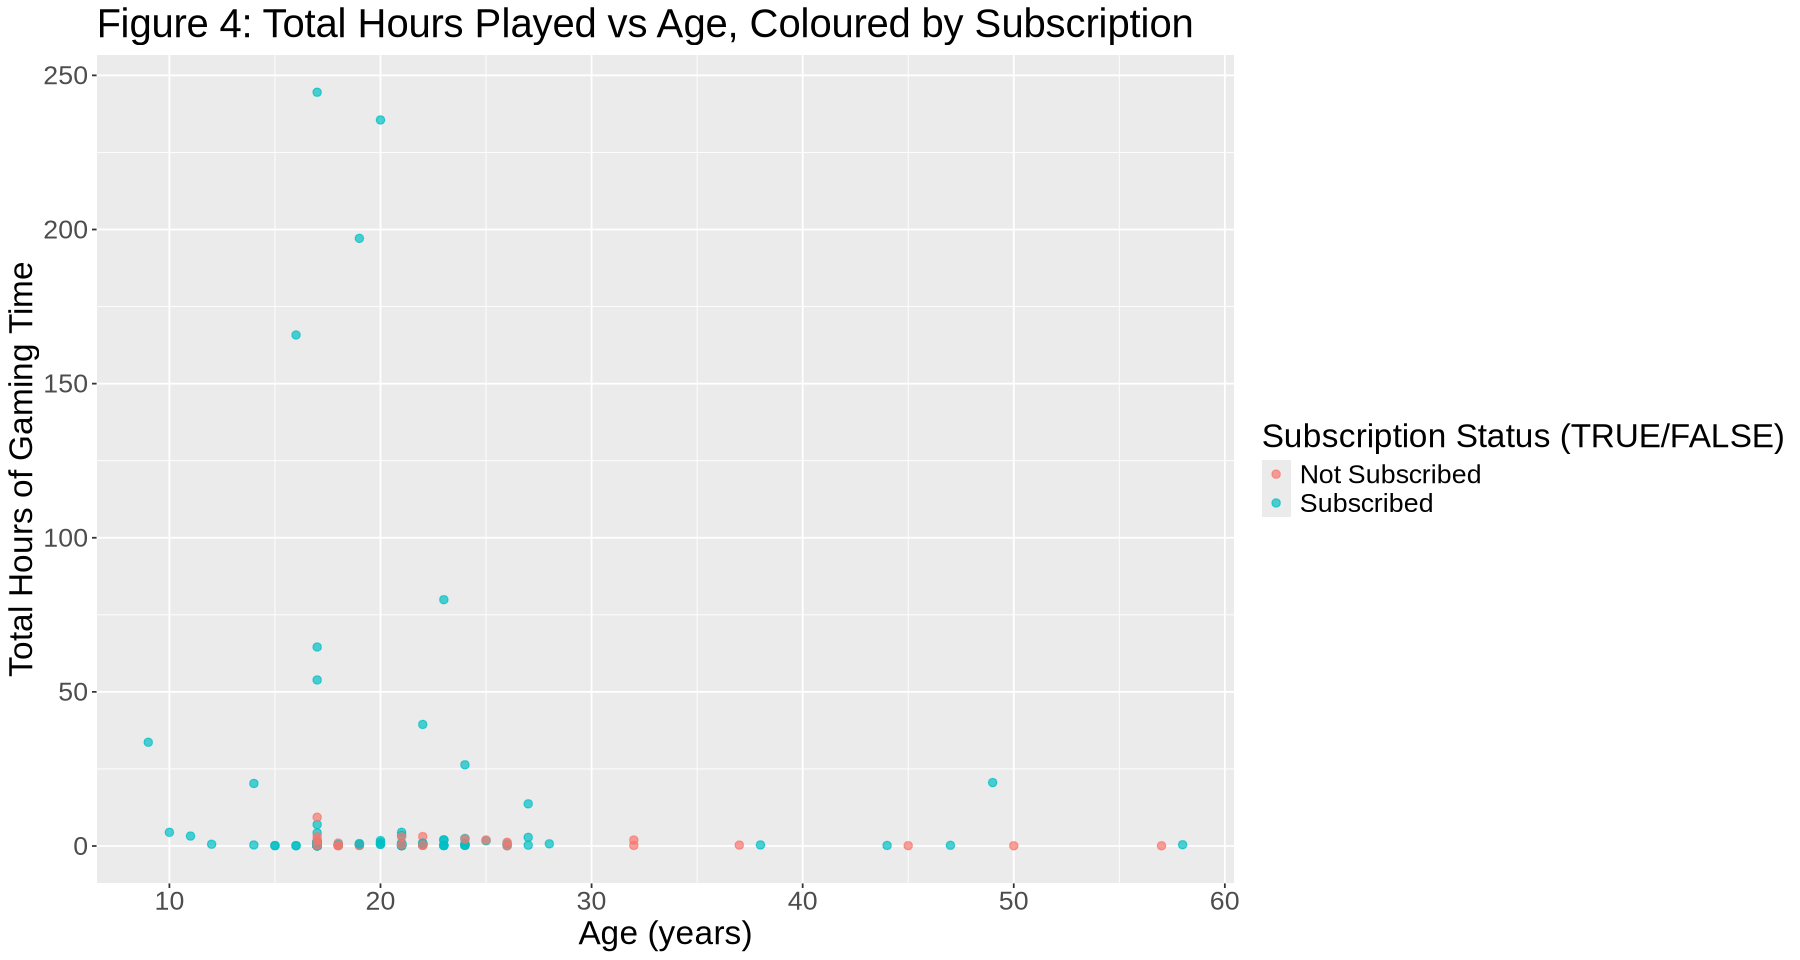

In [11]:
options(repr.plot.width=15,repr.plot.height=8)
scaled_scatterplot<-ggplot(full_data,aes(x = Age,y = total_hours, color = subscribe))+
    geom_point(alpha=0.7, size=2)+
    labs(x="Age (years)",
         y="Total Hours of Gaming Time",
         title="Figure 4: Total Hours Played vs Age, Coloured by Subscription",
         color="Subscription Status (TRUE/FALSE)")+
    theme(text=element_text(size=20))
scaled_scatterplot

table(full_data$subscribe)

Warning message:
“Removed 22 rows containing missing values or values outside the scale range
(`geom_point()`).”



Not Subscribed     Subscribed 
            13             37 

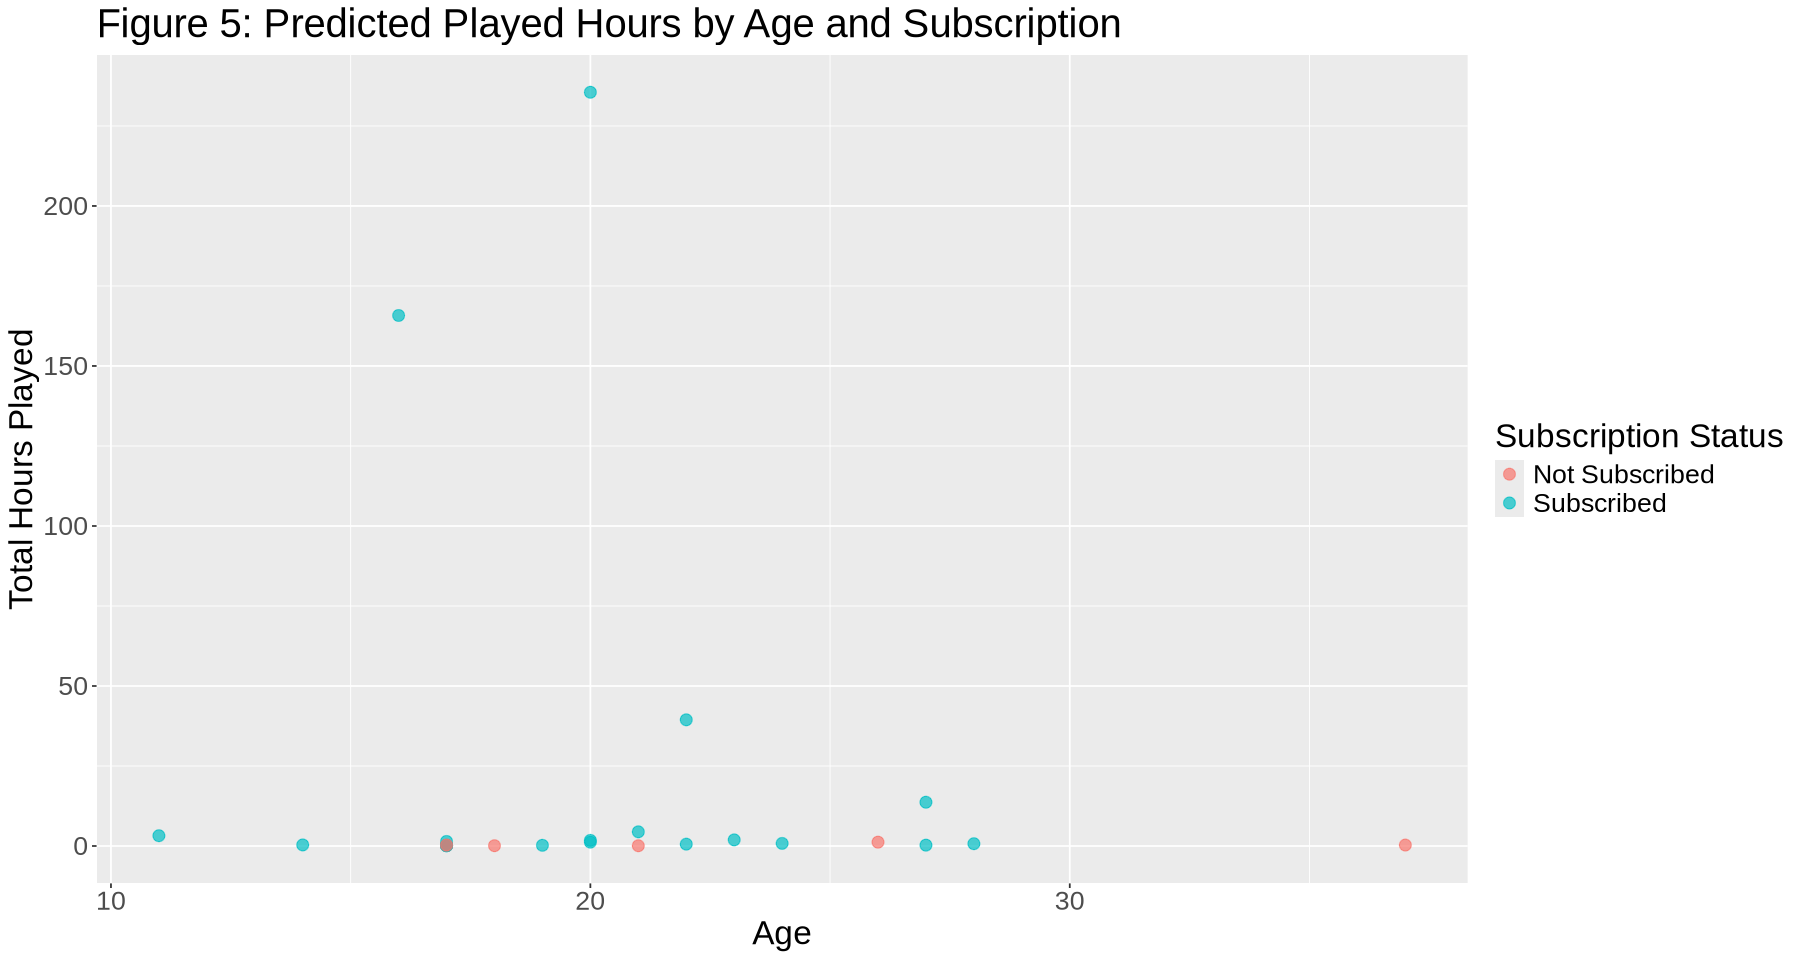

In [12]:
options(repr.plot.width=15,repr.plot.height=8)
scatterplot_preds<-ggplot(preds, aes(x = Age, y = total_hours, color = subscribe)) +
    geom_point(alpha = 0.7, size = 3) +
    labs(x = "Age",
         y = "Total Hours Played",
         color = "Subscription Status",
         title = "Figure 5: Predicted Played Hours by Age and Subscription") +
    theme(text=element_text(size=20))
scatterplot_preds

table(preds$subscribe)

Warning message:
“Removed 73 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 22 rows containing missing values or values outside the scale range
(`geom_point()`).”


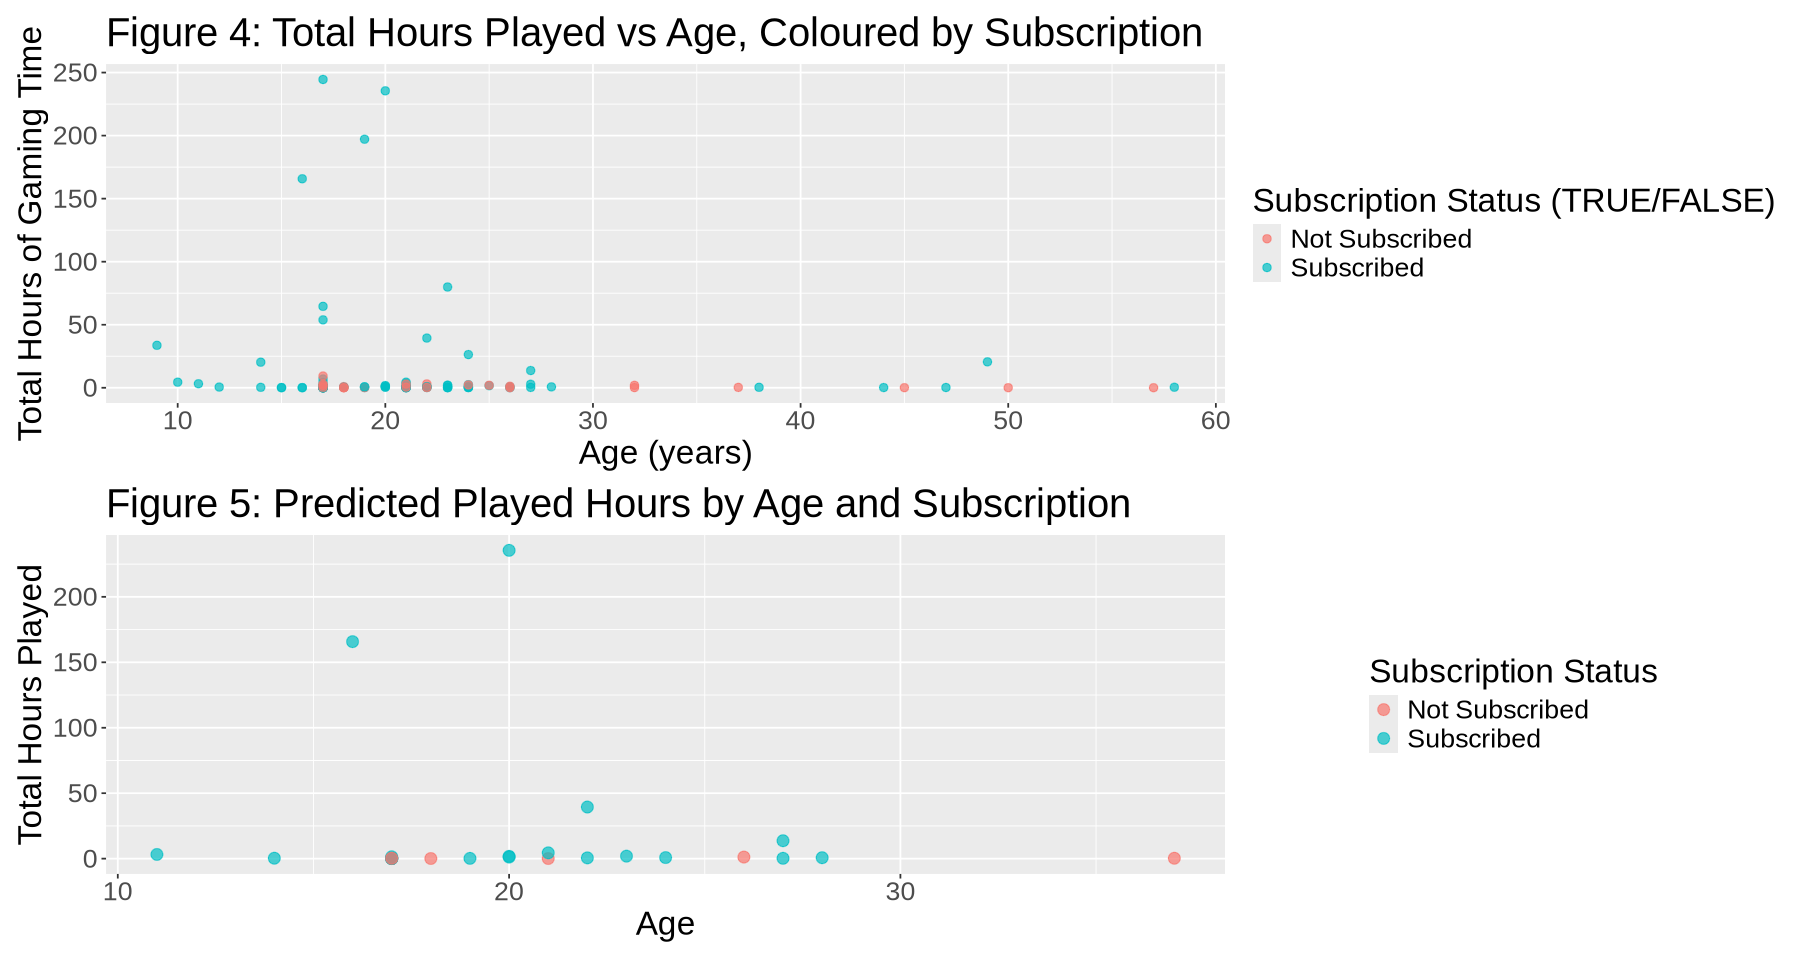

In [13]:
library(patchwork)
scaled_scatterplot/scatterplot_preds

The predicted subscribed vs not subscribed as well as the ratio is quite similar to the data provided, the only main difference is fewer data points, as well as fewer data points that played for longer hours. The predicted visualization does provide some information and the overall trend that those who play more are subscribed, but it does not capture the clustering around ages 15-25 as clearly as the previous graph, or enough data points to see a clear trend between the variables. 

**Description of the Analysis**: \
The aim of this analysis is to understand which kinds of players contribute the most gameplay time, and how factors such as **age** and **newsletter subscription status** can be used to **predict total hours played**. To accomplish this, we cleaned and merged gameplay session data, explored patterns through visualizations, and then built a **K-Nearest Neighbors (KNN) regression model** using the tidymodels framework. 

**1. Data Load and Preprocess** \
We firstly importe two datasets: 
- players.csv – demographic and subscription information for each player 
- sessions.csv – logs of individual gameplay sessions with start and end timestamps

The session data required cleaning before analysis. So we split the combined timestamps into separate date and time fields: 
-  Reconstructed these into proper date variables (start_dt, end_dt). 
- Computed the length of each session as duration_hours = end_dt – start_dt.

We then aggregated sessions per player to calculate: 

- total_hours_played
- session_count

These summaries were merged back into the player dataset to create full_data, containing demographic information and total hours played for each individual. 

**2. Exploratory Data Analysis** \
To better understand patterns, we created several visualizations: 
- Histogram of total hours played to examine the overall distribution of gameplay time. 
- Boxplot of total time played(hours) by subscription status to see if newsletter subscribers play more or less. 
- Scatterplot of age vs. total hours to explore how age relates to gameplay time. 

These plots provided initial intuition on potential predictors of player engagement. 

**3. Preparing the Data for Modeling**
Before fitting the KNN model, we split the data into:
- 75% training data 
- 25% testing data

We then constructed a recipe to preprocess predictors: \
1.	step_unknown() – handles missing categorical values. \
2.	step_dummy() – converts subscription status into dummy variables. \
3.	step_zv() – removes predictors with zero variance. \
4.	step_normalize() – scales numeric predictors (required for distance-based models like KNN). \
This recipe ensures that all predictors are cleaned and formatted properly.

**4. Build and Tune the KNN Regression Model**
To determine the best number of k :
- We created a grid of k values from 1 to 20.
- Applied 5-fold cross-validation on the training set.
- Tuned the model using tune_grid() and evaluated performance using rmse.
From these results, we selected the best-performing value of k using:
select_best(knn_tuned, metric = "rmse")
The workflow was then finalized with this optimal k. 

**5. Final Model Fit and Evaluation** \
The finalized KNN model was fit on the full training set, and predictions were made on the testing data. \
We evaluated the model's performance by computing:
- Root Mean Squared Error (rmse)
- Other metrics to compare predicted & actual total hours played.
This allowed us to quantify how well age and subscription status can explain variation in gameplay time.

**6. Colored Scatterplot**
To further explore the relationship between player demographics and gameplay behavior, we created a colored scatterplot showing how total hours played varies with age, while also incorporating newsletter subscription status. In this visualization: 
- Age is plotted on the x-axis. 
- Total hours played is plotted on the y-axis. 
- Points are color-coded by subscription status (“true” or “false”). 

This allows us to visually inspect whether subscribers tend to cluster at higher or lower gameplay levels compared to non-subscribers, and whether age interacts with subscription status in explaining total gameplay.

This helps confirm whether the groups are balanced or imbalanced, which is important for both interpretation and modeling.

**Summary** \
1.	Cleaned and merged gameplay session data \
2.	Summarized total hours per player \
3.	Explored patterns through visualizations \
4.	Prepared variables using a tidymodels recipe \
5.	Built and tuned a KNN regression model using cross-validation \
6.	Selected the best model and evaluated it on test data \
7. Colour the cluster for more better visualization